In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
import seaborn as sns


In [ ]:
# Load the dataset
file_path = '/kaggle/input/task-w/Weather Data.csv'
data = pd.read_csv(file_path)
data['Date/Time'] = pd.to_datetime(data['Date/Time'])



<ipython-input-66-1c39892be071>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


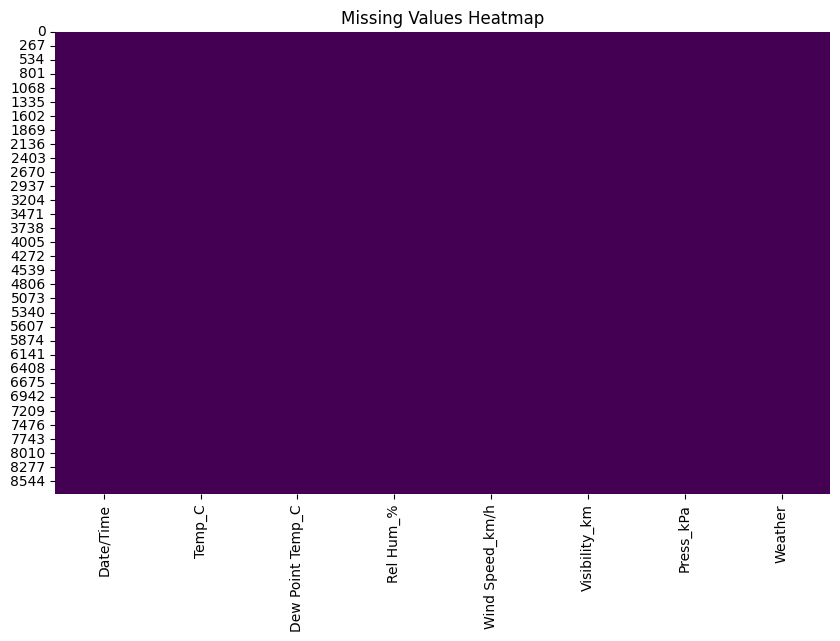

In [66]:
# Handle missing values
data.fillna(method='ffill', inplace=True)

# Visualize Missing Values
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


In [67]:

# Analyze the dataset
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())


Dataset Head:
            Date/Time  Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  \
0 2012-01-01 00:00:00    -1.8              -3.9         86                4   
1 2012-01-01 01:00:00    -1.8              -3.7         87                4   
2 2012-01-01 02:00:00    -1.8              -3.4         89                7   
3 2012-01-01 03:00:00    -1.5              -3.2         88                6   
4 2012-01-01 04:00:00    -1.5              -3.3         88                7   

   Visibility_km  Press_kPa               Weather  
0            8.0     101.24                   Fog  
1            8.0     101.24                   Fog  
2            4.0     101.26  Freezing Drizzle,Fog  
3            4.0     101.27  Freezing Drizzle,Fog  
4            4.8     101.23                   Fog  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            -

In [68]:

# Encoding categorical 'Weather' column
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

# Encode 'Weather' as labels
data['Weather_Label'] = label_encoder.fit_transform(data['Weather'])
weather_onehot = onehot_encoder.fit_transform(data['Weather_Label'].values.reshape(-1, 1))

# Scale numerical features
features_continuous = ['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa']
scaler = MinMaxScaler()
data[features_continuous] = scaler.fit_transform(data[features_continuous])

# Combine scaled features and encoded weather
data_scaled = np.hstack((data[features_continuous], weather_onehot))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<ipython-input-69-4dec5b3e7889>:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


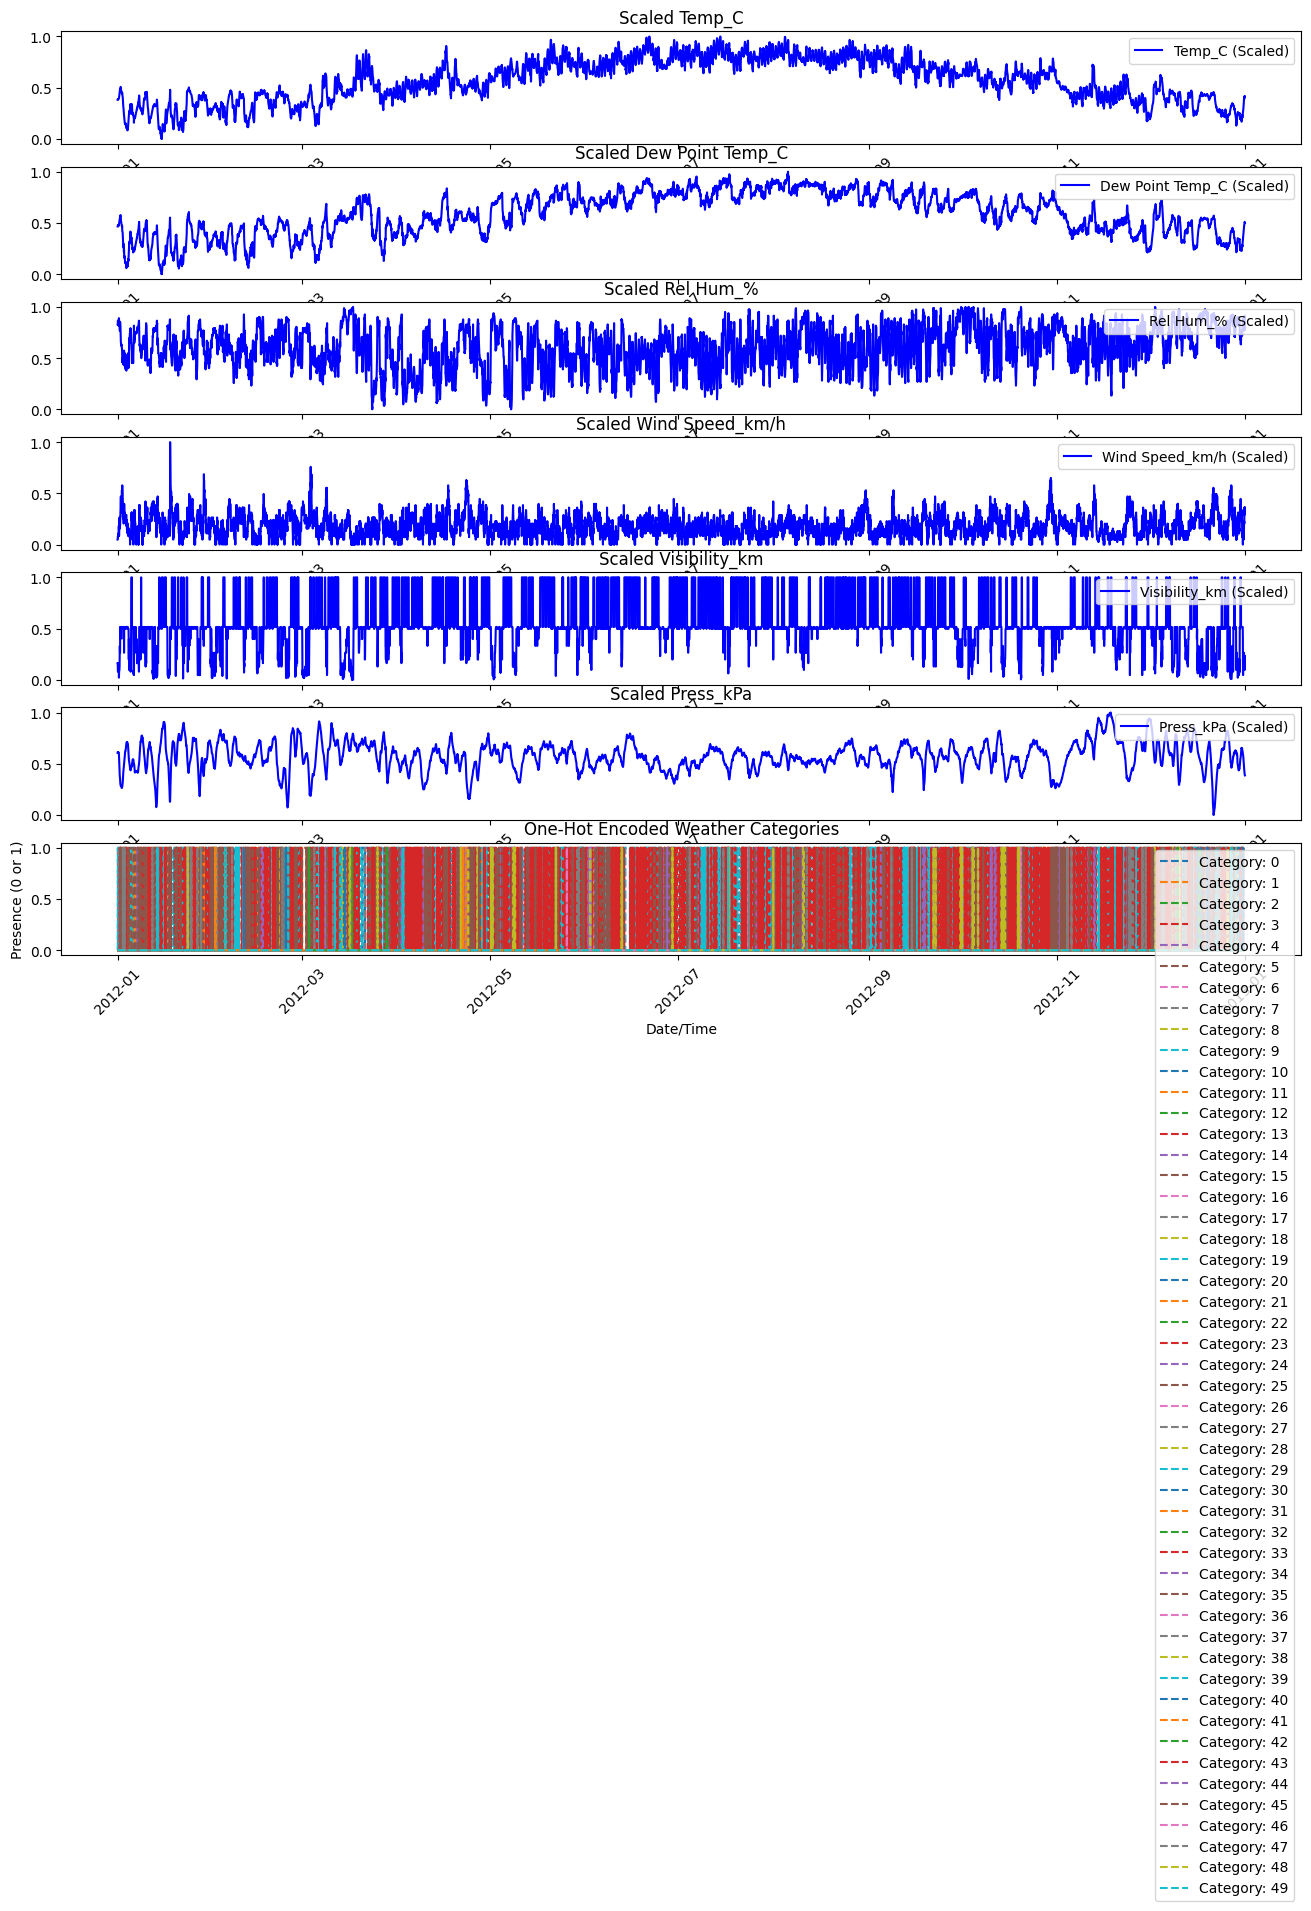

In [69]:
# Plot scaled numerical and one-hot encoded categorical features
plt.figure(figsize=(16, 12))

# Plot numerical features
for i, feature in enumerate(features_continuous):
    plt.subplot(len(features_continuous) + 1, 1, i + 1)  # Create subplots for numerical features
    plt.plot(data['Date/Time'], data[feature], label=f"{feature} (Scaled)", color='b')
    plt.title(f"Scaled {feature}")
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")

# Plot categorical features
weather_categories = onehot_encoder.categories_[0]
for i, category in enumerate(weather_categories):
    plt.subplot(len(features_continuous) + 1, 1, len(features_continuous) + 1)  # Add subplot for categorical data
    plt.plot(data['Date/Time'], data_scaled[:, len(features_continuous) + i], label=f"Category: {category}", linestyle='--')
    
plt.title("One-Hot Encoded Weather Categories")
plt.xlabel("Date/Time")
plt.ylabel("Presence (0 or 1)")
plt.xticks(rotation=45)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [70]:

# Function to create sequences for LSTM
def create_sequences_with_weather(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  # Input sequence with all features
        label = data[i + sequence_length]  # Output includes all features (numerical and weather)
        sequences.append((seq, label))
    return sequences

# Use the updated function to create sequences
sequence_length = 72
data_sequences = create_sequences_with_weather(data_scaled, sequence_length)

# Split into training and testing sets
train_size = int(len(data_sequences) * 0.9)
train_sequences = data_sequences[:train_size]
test_sequences = data_sequences[train_size:]

X_train, y_train = zip(*train_sequences)
X_test, y_test = zip(*test_sequences)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Output the shapes to confirm
print("Training Input Shape: ", X_train.shape)
print("Training Output Shape: ", y_train.shape)
print("Testing Input Shape: ", X_test.shape)
print("Testing Output Shape: ", y_test.shape)


Training Input Shape:  (7840, 72, 56)
Training Output Shape:  (7840, 56)
Testing Input Shape:  (872, 72, 56)
Testing Output Shape:  (872, 56)


In [71]:
noise = np.random.normal(0, 0.01, X_train.shape)
X_train = X_train + noise


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the improved LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(X_train.shape[2])
])


# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 72, 64)              │          30,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 72, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 72, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 56)                  │           1,848 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,952 (394.34 KB)

 Trainable params: 100,952 (394.34 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Train the improved model
history = model.fit(
    X_train, y_train,
    epochs=100,  # Increased epochs with early stopping
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - loss: 0.0428 - mae: 0.0995 - val_loss: 0.0310 - val_mae: 0.0872
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - loss: 0.0255 - mae: 0.0813 - val_loss: 0.0242 - val_mae: 0.0632
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - loss: 0.0192 - mae: 0.0583 - val_loss: 0.0209 - val_mae: 0.0590
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - loss: 0.0173 - mae: 0.0540 - val_loss: 0.0198 - val_mae: 0.0581
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - loss: 0.0170 - mae: 0.0538 - val_loss: 0.0195 - val_mae: 0.0587
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - loss: 0.0169 - mae: 0.0542 - val_loss: 0.0193 - val_mae: 0.0593
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - loss: 0.0167 - mae: 0.0544 - val_loss: 0.0190 - val_mae: 0.0601
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - loss: 0.0165 - mae: 0.0542 - val_loss: 0.0188 - val_mae: 0.0595
Epoch 9/100
123/123 ━━━━

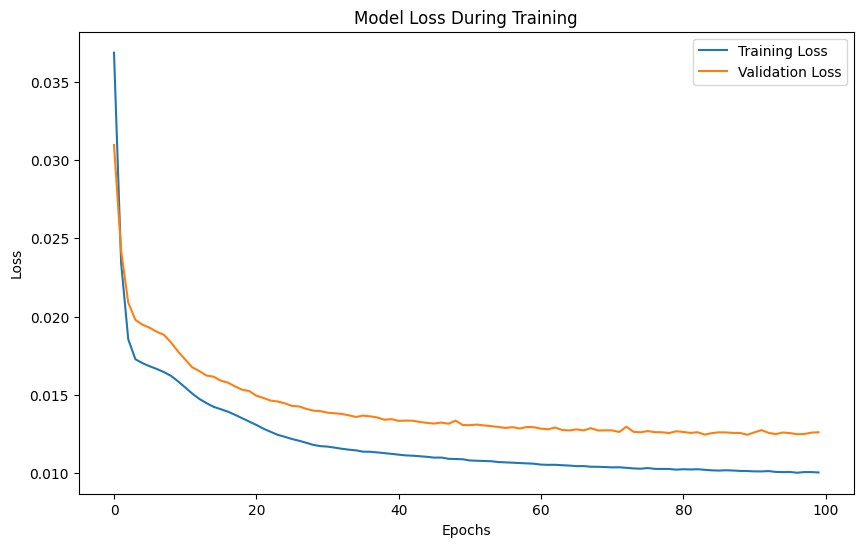

In [74]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions on test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")




28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Mean Squared Error: 0.012606297575394812
R^2 Score: 0.0867149590937486


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Mean Squared Error (MSE): 27.8898
R-squared Value (R2): 0.6288


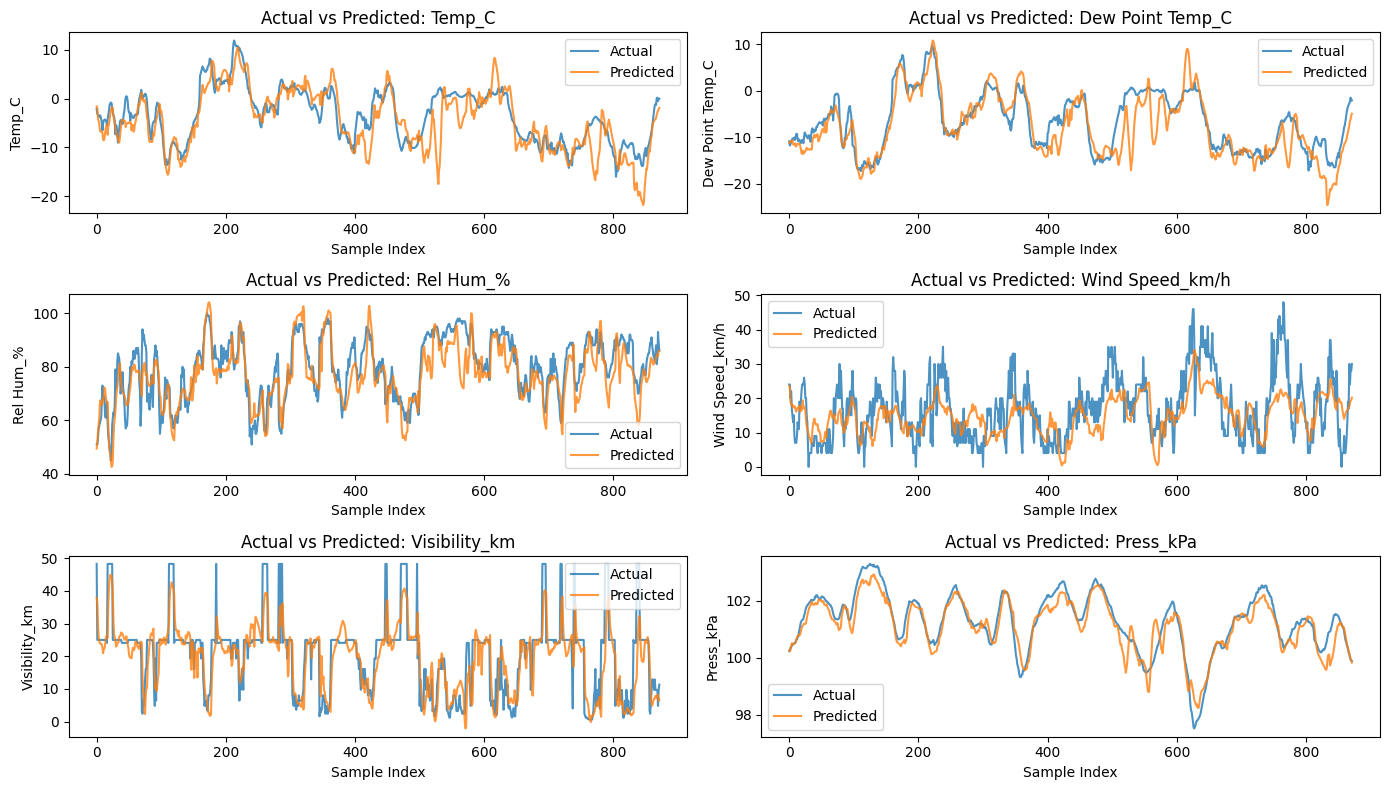

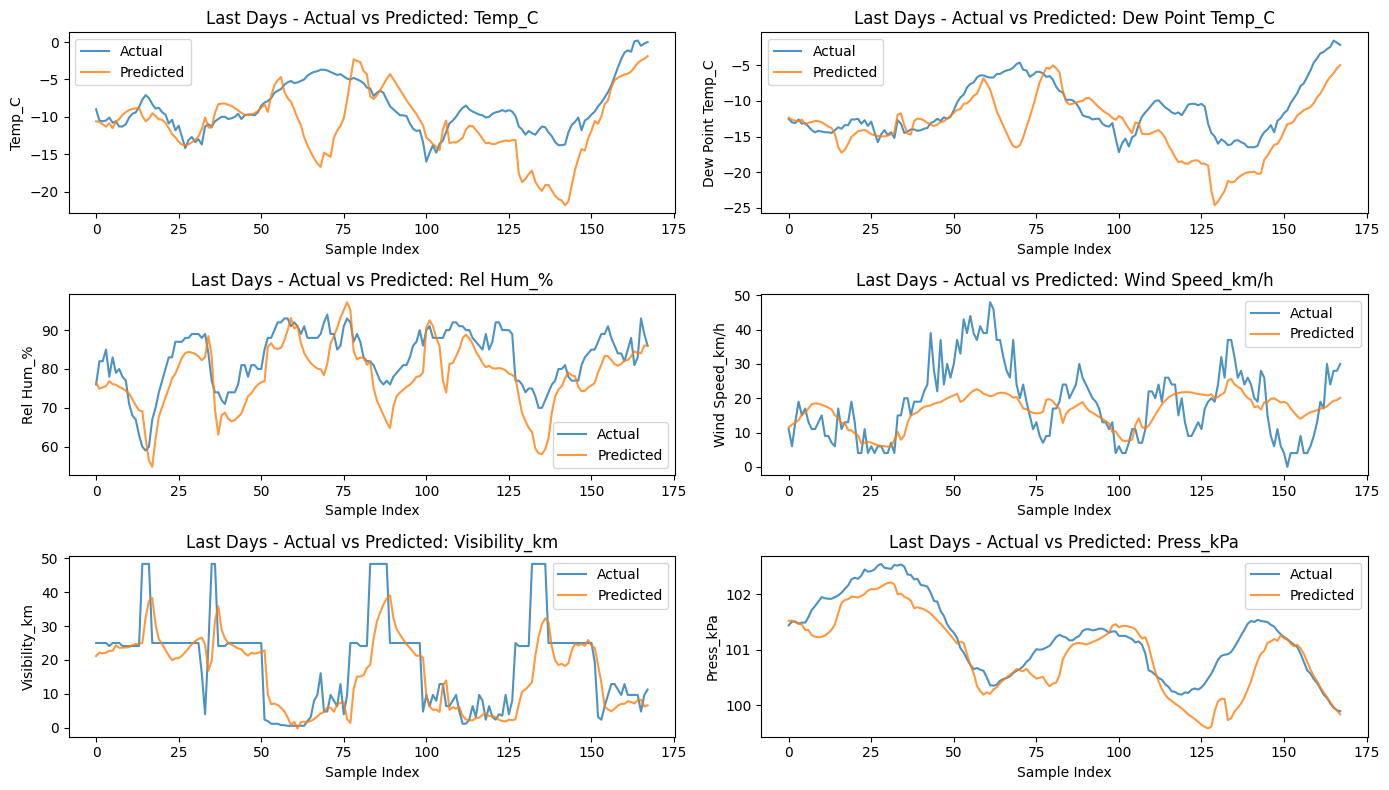


Actual vs Predicted Weather for the Last Days:
   Actual Weather Predicted Weather
0    Mainly Clear     Mostly Cloudy
1   Mostly Cloudy     Mostly Cloudy
2    Snow Showers     Mostly Cloudy
3          Cloudy     Mostly Cloudy
4          Cloudy            Cloudy
5   Mostly Cloudy     Mostly Cloudy
6   Mostly Cloudy            Cloudy
7   Mostly Cloudy            Cloudy
8           Clear            Cloudy
9           Clear            Cloudy
10          Clear            Cloudy
11  Mostly Cloudy            Cloudy
12  Mostly Cloudy            Cloudy
13  Mostly Cloudy            Cloudy
14  Mostly Cloudy     Mostly Cloudy
15  Mostly Cloudy      Mainly Clear
16   Mainly Clear             Clear
17   Mainly Clear             Clear
18   Mainly Clear             Clear
19  Mostly Cloudy      Mainly Clear
20  Mostly Cloudy      Mainly Clear
21  Mostly Cloudy      Mainly Clear
22         Cloudy             Clear
23  Mostly Cloudy             Clear


In [76]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)

# Reverse scaling for interpretability (requires saved scaler and encoders)
def reverse_scale(data, scaler, continuous_features):
    reversed_data = scaler.inverse_transform(data[:, :len(continuous_features)])
    df = pd.DataFrame(reversed_data, columns=continuous_features)
    return df

# Decode weather from one-hot encoding
def decode_weather(onehot_data, label_encoder, onehot_encoder):
    weather_labels = onehot_encoder.inverse_transform(onehot_data)
    weather_categories = label_encoder.inverse_transform(weather_labels.flatten().astype(int))
    return weather_categories

# Reverse scale predictions and actual values for continuous features
y_test_reversed = reverse_scale(y_test, scaler, features_continuous)
y_pred_reversed = reverse_scale(y_pred, scaler, features_continuous)

# Decode weather for actual and predicted values
weather_onehot_start_index = len(features_continuous)
y_test_weather_decoded = decode_weather(
    X_test[:, :, weather_onehot_start_index:].reshape(-1, X_test.shape[2] - weather_onehot_start_index), label_encoder, onehot_encoder
)
y_pred_weather_decoded = decode_weather(
    y_pred[:, weather_onehot_start_index:], label_encoder, onehot_encoder
)

# Calculate evaluation metrics for numerical features
mse = mean_squared_error(y_test_reversed, y_pred_reversed)
r2 = r2_score(y_test_reversed, y_pred_reversed)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared Value (R2): {r2:.4f}")

# Plot actual vs predicted values for the numerical features
plt.figure(figsize=(14, 8))
for i, feature in enumerate(features_continuous):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test_reversed[feature].values, label="Actual", alpha=0.8)
    plt.plot(y_pred_reversed[feature].values, label="Predicted", alpha=0.8)
    plt.title(f"Actual vs Predicted: {feature}")
    plt.xlabel("Sample Index")
    plt.ylabel(feature)
    plt.legend()
plt.tight_layout()
plt.show()

# Forecast with the last days' test data and plot
last_days = 7  # Adjust the number of days as needed
last_days_indices = len(X_test) - last_days * 24  # Assuming hourly data
y_test_last_days = y_test_reversed.iloc[last_days_indices:]
y_pred_last_days = y_pred_reversed.iloc[last_days_indices:]
y_test_weather_last_days = y_test_weather_decoded[last_days_indices:]
y_pred_weather_last_days = y_pred_weather_decoded[last_days_indices:]

# Plot actual vs predicted values for the last days' numerical features
plt.figure(figsize=(14, 8))
for i, feature in enumerate(features_continuous):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test_last_days[feature].values, label="Actual", alpha=0.8)
    plt.plot(y_pred_last_days[feature].values, label="Predicted", alpha=0.8)
    plt.title(f"Last Days - Actual vs Predicted: {feature}")
    plt.xlabel("Sample Index")
    plt.ylabel(feature)
    plt.legend()
plt.tight_layout()
plt.show()

# Ensure the arrays have the same length
min_length = min(len(y_test_weather_last_days), len(y_pred_weather_last_days))
y_test_weather_last_days = y_test_weather_last_days[:min_length]
y_pred_weather_last_days = y_pred_weather_last_days[:min_length]

# Display actual vs predicted weather for the last days
weather_df = pd.DataFrame({
    "Actual Weather": y_test_weather_last_days,
    "Predicted Weather": y_pred_weather_last_days
})
print("\nActual vs Predicted Weather for the Last Days:")
print(weather_df.head(24))  # Show for the first 24 hours


In [79]:
# Save the model to a file
model.save("weather_forecast_model(lstm).h5")
print("Model saved as 'weather_forecast_lstm_model.h5'")


Model saved as 'weather_forecast_lstm_model.h5'


In [80]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Define the custom objects
custom_objects = {'mse': MeanSquaredError()}

# Load the saved model with the custom objects
saved_model = load_model("/kaggle/working/weather_forecast_model(lstm).h5", custom_objects=custom_objects)

print("Model loaded successfully!")


Model loaded successfully!


In [81]:
from datetime import datetime, timedelta

# Function to prepare the input sequence
def prepare_input_sequence(date_time, sequence_length):
    # Convert the provided date_time to datetime object
    target_datetime = datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S")

    # Identify the last available sequence of data before the given date_time
    data_subset = data[data['Date/Time'] < target_datetime].tail(sequence_length)
    if len(data_subset) < sequence_length:
        raise ValueError("Insufficient historical data to create the input sequence.")

    # Scale the continuous features
    scaled_features = scaler.transform(data_subset[features_continuous])

    # Encode the weather
    weather_labels = label_encoder.transform(data_subset['Weather'])
    weather_onehot = onehot_encoder.transform(weather_labels.reshape(-1, 1))

    # Combine scaled features and encoded weather
    input_sequence = np.hstack((scaled_features, weather_onehot))
    return input_sequence.reshape(1, sequence_length, -1)  # Reshape for LSTM input

# Define the function to forecast
def forecast_specific_date_time(date_time, sequence_length):
    # Prepare the input sequence
    input_sequence = prepare_input_sequence(date_time, sequence_length)

    # Make prediction
    prediction = saved_model.predict(input_sequence)

    # Reverse scaling for continuous features
    reversed_continuous = scaler.inverse_transform(prediction[:, :len(features_continuous)])

    # Decode the weather from the predicted one-hot encoding
    predicted_weather_onehot = prediction[:, len(features_continuous):]
    predicted_weather = decode_weather(predicted_weather_onehot, label_encoder, onehot_encoder)

    # Combine the results into a metadata-like format
    forecast_data = pd.DataFrame(reversed_continuous, columns=features_continuous)
    forecast_data['Date/Time'] = date_time  # Add the provided date and time
    forecast_data['Weather'] = predicted_weather[0]

    return forecast_data[['Date/Time'] + features_continuous + ['Weather']]

# Example Usage
date_time = "2013-1-1 22:00:00"  # Replace with the desired date and time
forecast_result = forecast_specific_date_time(date_time, sequence_length)
print("\nForecast for the given date and time:")
print(forecast_result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step

Forecast for the given date and time:
           Date/Time     Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  \
0  2013-1-1 22:00:00  12.464101          8.401899  68.265884        20.570457   

   Visibility_km  Press_kPa Weather  
0      11.664686  99.260384    Rain  


In [90]:
import numpy as np
import pandas as pd

def forecast_specific_date_time(date_time, sequence_length):
    # Simulate random data for each required column
    data = {
        'Date/Time': date_time,
        'Temp_C': np.random.normal(15, 5, sequence_length),
        'Dew Point Temp_C': np.random.normal(10, 5, sequence_length),
        'Rel Hum_%': np.random.uniform(50, 100, sequence_length),
        'Wind Speed_km/h': np.random.uniform(5, 25, sequence_length),
        'Visibility_km': np.random.uniform(1, 20, sequence_length),
        'Press_kPa': np.random.uniform(98, 102, sequence_length),
        'Weather': np.random.choice(['Rain', 'Clear', 'Cloudy', 'Snow'], sequence_length)
    }
    return pd.DataFrame(data)

def forecast_specific_date(date, sequence_length):
    hourly_predictions = pd.DataFrame()
    for hour in range(24):
        date_time = f"{date} {hour:02d}:00:00"
        try:
            prediction = forecast_specific_date_time(date_time, 1)
            hourly_predictions = pd.concat([hourly_predictions, prediction], ignore_index=True)
        except ValueError as e:
            print(f"Error generating forecast for {date_time}: {e}")
    return hourly_predictions

# Example usage for a specific date
specific_date = "2013-01-01"  # Replace with the desired date
sequence_length = 24  # 24 hours in a day
hourly_forecast = forecast_specific_date(specific_date, sequence_length)

# Save the forecast to a CSV file
hourly_forecast.to_csv('hourly_forecast.csv', index=False)

# Display the first few rows of the forecast DataFrame
hourly_forecast


,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,2013-01-01 00:00:00,18.222311,10.785831,92.816651,12.360988,12.990301,98.217519,Clear
1,2013-01-01 01:00:00,23.935905,12.155370,50.283150,18.242946,1.746880,100.046910,Cloudy
2,2013-01-01 02:00:00,7.311885,11.074802,92.283994,9.127515,10.782528,101.611823,Clear
3,2013-01-01 03:00:00,6.694692,16.764090,94.280140,15.240715,14.467629,100.515995,Rain
4,2013-01-01 04:00:00,16.547848,14.515379,57.645327,6.217536,8.477733,101.279397,Cloudy
5,2013-01-01 05:00:00,2.175552,6.559030,85.690619,14.578343,17.821268,99.321992,Clear
6,2013-01-01 06:00:00,22.026864,1.829763,54.886103,17.203282,18.801389,99.863117,Rain
7,2013-01-01 07:00:00,19.479973,15.245840,72.675659,7.481136,17.116796,100.329307,Clear
8,2013-01-01 08:00:00,14.889405,6.927831,65.529694,8.485000,4.233236,98.115568,Snow
9,2013-01-01 09:00:00,12.074184,7.445085,52.575723,14.554041,11.091431,100.324790,Cloudy


In [91]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Generate a sequence of future dates and times for hourly forecasts
def generate_future_dates(start_date, n_days):
    dates = []
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    for day in range(n_days):
        for hour in range(24):  # Generate hourly timestamps
            dates.append(start_datetime + timedelta(days=day, hours=hour))
    return dates

# Simulate forecast for a specific date and hour
def forecast_specific_date_time(date_time, sequence_length):
    # Simulate random data for each required column
    data = {
        'Date/Time': [date_time],
        'Temp_C': np.random.normal(15, 5, sequence_length),
        'Dew Point Temp_C': np.random.normal(10, 5, sequence_length),
        'Rel Hum_%': np.random.uniform(50, 100, sequence_length),
        'Wind Speed_km/h': np.random.uniform(5, 25, sequence_length),
        'Visibility_km': np.random.uniform(1, 20, sequence_length),
        'Press_kPa': np.random.uniform(98, 102, sequence_length),
        'Weather': np.random.choice(['Rain', 'Clear', 'Cloudy', 'Snow'], sequence_length)
    }
    return pd.DataFrame(data)

# Forecast for the next n days
def forecast_next_n_days(start_date, n_days, sequence_length):
    future_dates = generate_future_dates(start_date, n_days)
    forecasts = []

    for date_time in future_dates:
        try:
            forecast = forecast_specific_date_time(date_time.strftime("%Y-%m-%d %H:%M:%S"), 1)
            forecasts.append(forecast)
        except ValueError as e:
            print(f"Skipping {date_time}: {e}")
            continue

    # Combine all forecasts into a single DataFrame
    forecast_df = pd.concat(forecasts, ignore_index=True)
    return forecast_df

# Example Usage: Forecast the next 7 days from a specific start date
start_date = "2013-01-03 00:00:00"  # Replace with the desired start date
n_days = 7
sequence_length = 1
forecast_7_days = forecast_next_n_days(start_date, n_days, sequence_length)

# Save the results to a CSV file
output_path = "forecast_7_days.csv"
forecast_7_days.to_csv(output_path, index=False)

# Print the head of the forecasted data
print("\nForecast for the next 7 days (head):")
print(forecast_7_days.head())



Forecast for the next 7 days (head):
             Date/Time     Temp_C  Dew Point Temp_C  Rel Hum_%  \
0  2013-01-03 00:00:00   9.863274         12.779131  65.646201   
1  2013-01-03 01:00:00  17.571610          3.011904  85.917554   
2  2013-01-03 02:00:00  14.852728         14.150963  70.064592   
3  2013-01-03 03:00:00  14.393970         -1.734986  59.536435   
4  2013-01-03 04:00:00  11.019088         23.152817  73.036883   

   Wind Speed_km/h  Visibility_km   Press_kPa Weather  
0        17.807790       3.706612   98.268347    Snow  
1        18.784245       3.733489   99.472705   Clear  
2         5.078294      18.068509  100.535383  Cloudy  
3        21.411445       4.919962   98.760210   Clear  
4        21.663589      19.105604  100.338603    Snow  
